# Predikcia zárobku filmov
## Zdroj dát: [Kaggle](https://www.kaggle.com/stephanerappeneau/350-000-movies-from-themoviedborg) (ThemovieDB)

## TODOs
* Nahradit unknown budget values medianom/priemerom
* Normalizovat hodnoty na skale <0, 1> - pre ktore stlpce?
* Binarizacia kategorickych stlpcov
* Pridat do LR vsetky stplce (fixnut errory s hodnotami)
* Confusion metrics
* Classification report
* Accuracy je nepodstatna
* Zoznam pouzitej literatury


Successfully loaded the dataset from data/themoviedb/moviesKnownRevenue.csv
Rows: 8688, columns: 23
Coefficients: [[-5.25172409e+06  1.61902631e+00 -2.67715425e+06  8.16024611e+04]]
Mean squared error: 3.41799e+15
Variance score: 0.74118


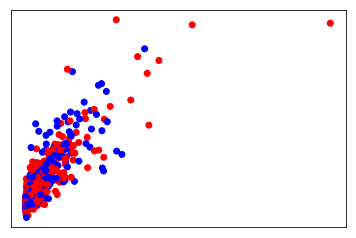

In [66]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import traceback
import re

from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
    
    
# Loads the dataset CSV file from a given path
def load_dataset(filepath, data_delimiter):
    # Load the file to a dataframe via Pandas
    try:
        df = pd.read_csv(filepath, delimiter=data_delimiter, low_memory=False)
    
        print("Successfully loaded the dataset from " + filepath)
        print("Rows: " + str(df.shape[0]) + ", columns: " + str(df.shape[1]))
        
        return df
    except:
        traceback.print_exc()
        print("Failed to load the dataset from " + filepath)
        return
   
   
def filter_by_bottom_threshold(df, colname, threshold, equal=False):
    print("Dropping '{}' values below the following threshold: {}".format(colname, threshold))
    
    rows_before = df.shape[0]
    
    if equal:
        df = df[df[colname] >= threshold]
    else:
        df = df[df[colname] > threshold]
    
    print("Dropped {} entries".format(rows_before - df.shape[0]))
    return df


def filter_by_upper_threshold(df, colname, threshold, equal=False):
    print("Dropping '{}' values above the following threshold: {}".format(colname, threshold))
    
    rows_before = df.shape[0]
    
    if equal:
        df = df[df[colname] <= threshold]
    else:
        df = df[df[colname] < threshold]
    
    print("Dropped {} entries".format(rows_before - df.shape[0]))
    return df
    
    
def drop_nan_values(df, colnames, keep_zeros=True):
    df = df.dropna(axis=0, how='any', subset=colnames)
    rows_before = df.shape[0]
    
    if not keep_zeros:
        for col in colnames:
            df = df[df[col] > 0]
        
    print("Dropped {} zero/NaN entries".format(rows_before - df.shape[0]))
    return df


def drop_outliers_iqb(df, colnames):
    for col in colnames:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        df = df.query('(@Q1 - 1.5 * @IQR) <= ' + col + ' <= (@Q3 + 1.5 * @IQR)')
    return df


def show_user_ratings_histogram(df):
    df['vote_average'].plot.hist(alpha=0.5, bins=10, range=(0, 10), normed=True)
    plt.xlabel("Vote_average")
    plt.ylabel("Percentage")
    plt.show()
    
    
def show_scatter_plot(df, col1, col2):
    plt.scatter(df[col1], df[col2])
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()
    

def show_scatter_matrices_plot(df):
    # Scatter matrices plot
    sm = scatter_matrix(df, alpha=0.3, figsize=(12, 12), diagonal='kde', grid=True, edgecolors='blue')

    #Change label rotation
    for s in sm.reshape(-1):
        s.xaxis.label.set_size(8)
        s.xaxis.label.set_rotation(45)

        s.yaxis.label.set_size(8)
        s.yaxis.label.set_rotation(45) 

    #May need to offset label when rotating to prevent overlap of figure
    [s.get_yaxis().set_label_coords(-0.5, 0.5) for s in sm.reshape(-1)]

    #Hide all ticks
    [s.set_xticks(()) for s in sm.reshape(-1)]
    [s.set_yticks(()) for s in sm.reshape(-1)]
    
    plt.savefig("scatter_matrix.png", dpi=300)
    plt.show()
    
def binarize_categorical_feature(df, colname):
    categories = []
    
    #fix nan
    df[colname] = df[colname].fillna('')
    
    #Get all categories with row index in separet rows
    for i in range(len(df[colname])):
        for element in re.split("\|", df[colname][i]):
            categories.append([i, element])
    
    #binarize_feature
    feature_with_num_label = pd.DataFrame.from_records(categories, columns=['number_label', 'category'])
    binary_feature = feature_with_num_label.pivot_table(
        index=['number_label'], columns=['category'], aggfunc=[len], fill_value=0)
    
    #use string indexes for columns in array instead of tuples as (len, category)
    binary_feature.columns = [column[1] for column in binary_feature.columns]
    
    #add binarized_feature columns to dataframe without fist (len) column
    df = pd.concat([binary_feature.iloc[:, 1:], df], axis=1)
    
    #remove old column from dataframe
    df = df.drop(colname, axis=1)
    
    return df

def get_polynomial_features(df, deg = 2):
    poly_features = PolynomialFeatures(degree = deg)
    poly_features = poly_features.fit(df)
    columns_names  = poly_features.get_feature_names(df.columns)
    df = poly_features.transform(df)
    
    return pd.DataFrame(df, columns = columns_names)

def encode_strings(df, columns):
    labelencoder = LabelEncoder()
    for column in columns:
        df[column] = df[column].fillna('')
        df[column] = labelencoder.fit_transform(df[column])
        
    return df
    
    
def get_simple_lr_model(df, data, target):
    data = data.values.reshape(data.shape[0], data.shape[1])
    target = target.values.reshape(target.shape[0], 1)
    
    x_train = data[:3000]
    x_test = data[3000:6000]
    
    y_train = target[:3000]
    y_test = target[3000:6000]

    lm = linear_model.LinearRegression()
    model = lm.fit(x_train, y_train)

    y_pred = lm.predict(x_test)
    
    # The coefficients
    print('Coefficients:', lm.coef_)
    # The mean squared error
    print("Mean squared error: %g" % mean_squared_error(y_test, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(y_test, y_pred))

    # Plot outputs
    # plt.scatter(x_test, y_test,  color='black')
    plt.scatter(y_test, y_pred, linewidth=1, color=['red', 'blue'])

    plt.xticks(())
    plt.yticks(())

    plt.show()
    
    
df = load_dataset('data/themoviedb/moviesKnownRevenue.csv', ';')

# Drop zero/NaN value rows
# df = drop_nan_values(df, ['revenue'], False)

# Drop unnecessary columns
df = df.drop(['id'], axis=1)

df = encode_strings(df, ['original_language', 'production_countries', 'spoken_languages'])

#binarize genres
#pd.set_option('display.max_columns', 50)
df = binarize_categorical_feature(df, 'genres')
#print ("Dataframe:")
#display(df)

poly_df = get_polynomial_features(df[['production_companies_number', 'budget', 'vote_average', 'vote_count', 'original_language']], 2)

##############################

# User ratings histogram
# show_user_ratings_histogram(df)

# Scatter plot of revenue & budget
# show_scatter_plot(df, 'budget', 'revenue')

# Scatter matrices
# show_scatter_matrices_plot(df)

# A basic linear regression model
lm = get_simple_lr_model(df, df[['production_companies_number', 'budget', 'vote_average', 'vote_count']], df['revenue'])
